In [1]:
# %pip install diffrax --quiet
import diffrax
print(f"diffrax version={diffrax.__version__}")
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.50'

diffrax version=0.5.0


# Toy problem

Solve Langevin SDE:
$$dX = \frac 1 2 \nabla_X \log \mathcal N(X\mid 0,1)dt  + dB= -\frac 1 2 Xdt + dB$$

In [2]:
from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, UnsafeBrownianPath

shape = (2,3)
diffusion = lambda t, y, args: jnp.ones(shape)
vf_val = diffusion(None,None,None)
print(f"The vector field value=\n{vf_val}.\n")

# Let's check for Brownian control
brownian_motion = VirtualBrownianTree(0, 1, tol=0.01, shape=shape, key=jr.PRNGKey(0))
terms = ControlTerm(diffusion, brownian_motion)
contr_val = brownian_motion.evaluate(0.1,.2)
print(f"Brownian control value=\n{jnp.array_str(contr_val, precision=2)},")
print(f"then term product returns=\n{jnp.array_repr(terms.prod(vf_val, contr_val), precision=2)}")
print(f"while piecewise returns=\n{jnp.array_str(vf_val * contr_val, precision=2)}.\n")

# Let's make the time control $dt$ multidimensional
class get_control():
    def __init__(self, contr, y_shape):
        self.contr = contr
        self.y_shape = y_shape
    def evaluate(self, t0, t1):
        return self.contr(t0, t1)*jnp.ones(self.y_shape)
    def __call__(self, t0, t1):
        return self.evaluate(t0, t1)

termsODE = ODETerm(lambda x:x)
control = get_control(termsODE.contr, shape)
terms = ControlTerm(termsODE.vector_field, control)
contr_val = terms.contr(t0=0,t1=2)
print(f"Multidimensional time control value=\n{contr_val},")
print(f"then term product returns=\n{terms.prod(vf_val, contr_val)}")
print(f"while piecewise returns=\n{vf_val * contr_val}.\n")

2024-03-18 10:50:57.222712: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


The vector field value=
[[1. 1. 1.]
 [1. 1. 1.]].

Brownian control value=
[[-0.07  0.45 -0.11]
 [ 0.16 -0.1   0.26]],
then term product returns=
ArrayImpl([[-0.07,  0.45, -0.11],
           [ 0.16, -0.1 ,  0.26]], dtype=float32)
while piecewise returns=
[[-0.07  0.45 -0.11]
 [ 0.16 -0.1   0.26]].

Multidimensional time control value=
[[2. 2. 2.]
 [2. 2. 2.]],
then term product returns=
[[2. 2. 2.]
 [2. 2. 2.]]
while piecewise returns=
[[2. 2. 2.]
 [2. 2. 2.]].



The way it is implemented is: $dX = f \odot dt + g \cdot dB$, where $\odot$ is piecewise product and $\cdot$ is matrix product.

In [51]:
from jax import eval_shape
n_steps, dt = 100, 1e-1
t0, t1 = 0., n_steps*dt
drift = lambda t, y, args: -y/2
diffusion = lambda t, y, args: jnp.ones_like(y)
solver = Euler()
saveat = SaveAt(t1=True)

def diffrax_langevin(y, seed):
    # y_shape = eval_shape(lambda x: x, y)
    y_shape = y.shape
    print(f"{y_shape=}")
    brownian_motion = VirtualBrownianTree(t0, t1, tol=dt/10, shape=y_shape, key=seed)
    terms = MultiTerm(ODETerm(drift), ControlTerm(diffusion, brownian_motion))
    sol = diffeqsolve(terms, solver, t0, t1, dt0=dt, y0=y, max_steps=n_steps+1, saveat=saveat)
    return sol.ys[:n_steps]

def my_langevin(y, seed):
    current = y
    meshes = [current]
    brown = jr.normal(seed, (n_steps,*y.shape))
    for i in range(n_steps-1):
        current = current + drift(None, current, None)*dt + diffusion(None, current, None) * brown[i]*dt**.5
        meshes.append(current)
    return np.array(meshes)

In [52]:
shape = (8,8)
init = jr.normal(jr.PRNGKey(1), shape)
meshes1 = diffrax_langevin(init, jr.PRNGKey(5))
meshes2 = my_langevin(init, jr.PRNGKey(3))
meshes1.shape, meshes2.shape

y_shape=(8, 8)


((1, 8, 8), (100, 8, 8))

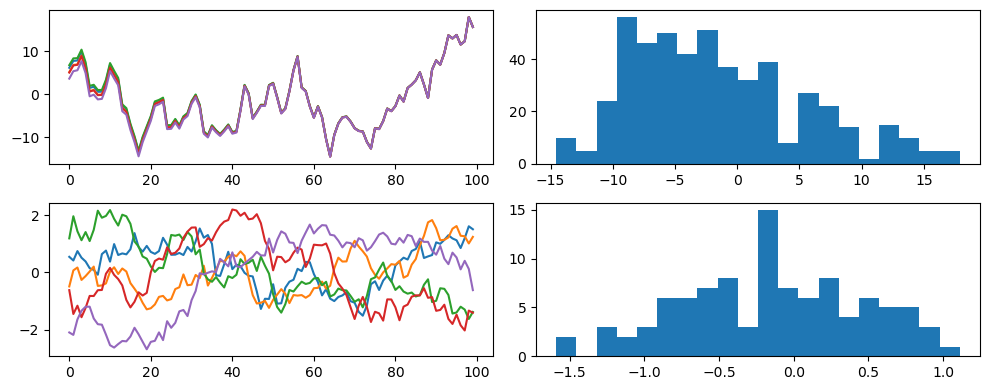

In [57]:
n_toplot = 5
plt.figure(figsize=(10,4))
plt.subplot(221)
plt.plot(meshes1[:,:n_toplot,0])
plt.subplot(222)
plt.hist(meshes1[:,:n_toplot,0].reshape(-1), bins=20)
plt.subplot(223)
plt.plot(meshes2[:,:n_toplot,0])
plt.subplot(224)
plt.hist(meshes2[:,n_toplot,0].reshape(-1), bins=20)
plt.tight_layout(), plt.show();

In [59]:
from matplotlib import animation, rc
rc('animation', html='html5')

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
vmax = 2
quad1 = plt.pcolormesh(meshes1[0], vmin=-10*vmax, vmax=10*vmax)
plt.title("diffrax langevin")
plt.colorbar()
plt.subplot(1,2,2)
quad2 = plt.pcolormesh(meshes2[0], vmin=-vmax, vmax=vmax)
plt.title("my langevin")
plt.colorbar()
plt.tight_layout()

def update(i):
    quad1.set_array(meshes1[i])
    quad2.set_array(meshes2[i])

anim = animation.FuncAnimation(plt.gcf(), update, frames=len(meshes1), interval=100)
plt.close(), display(anim);

In [ ]:
from matplotlib import animation, rc
rc('animation', html='html5')

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
vmax = 20
quad1 = plt.pcolormesh(meshes1[0], vmin=-10*vmax, vmax=10*vmax)
plt.title("diffrax langevin")
plt.colorbar()
plt.subplot(1,2,2)
quad2 = plt.pcolormesh(meshes2[0], vmin=-vmax, vmax=vmax)
plt.title("my langevin")
plt.colorbar()
plt.tight_layout()

def update(i):
    quad1.set_array(meshes1[i])
    quad2.set_array(meshes2[i])

anim = animation.FuncAnimation(plt.gcf(), update, frames=len(meshes1), interval=100)
plt.close(), display(anim);

# Which operation to use for control term product?

Specification:
* Should be able to perform both piecewise and matrix product.
* Without extra computational cost.
* Preferably without reshaping arrays.

In [136]:
def diffrax_prod(a, b):
    return jnp.tensordot(a, b, jnp.ndim(b))

def my_prod(a, b):
    return jnp.einsum('...k,k...->...', a, b)

a = jr.randint(jr.PRNGKey(0), (2,2), minval=0, maxval=5)
b = jr.randint(jr.PRNGKey(1), (2,2), minval=0, maxval=5)

# Matrix
print(f"\n# MATRIX=\n{a@b}.")
c, d = a, b
print(f"\n{c.shape=}, {d.shape=}\n")
print(f"diffrax_prod=\n{diffrax_prod(a, b)}")
print(f"my prod=\n{my_prod(c,d)}")

# Piecewise
print(f"\n# PIECEWISE=\n{a*b},")
# c, d = a[:,:,None], b[None]
c, d = a[:,:,None], b[:,:,None]
print(f"\n{c.shape=}, {d.shape=}\n")
print(f"my prod=\n{my_prod(c, d)}")


# MATRIX=
[[5 1]
 [2 0]].

c.shape=(2, 2), d.shape=(2, 2)

diffrax_prod=
7
my prod=
[5 0]

# PIECEWISE=
[[3 0]
 [4 0]],

c.shape=(2, 2, 1), d.shape=(2, 2, 1)

my prod=
[[9 3]
 [2 0]]
